Importing Libraries

In [ ]:
# Core data handling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for model building
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Scikit-learn for preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor

# Utilities
from tqdm.notebook import tqdm
import copy

# Set plot style and random seeds for reproducibility
plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Working from the final data "merged_energy_weather.csv"
df_final = pd.read_csv('merged_energy_weather.csv')
df_final = df_final.drop(df_final.columns[0], axis=1)
df_final.head()

,COMED_MW,temp_AUR,temp_BC,temp_DKC,temp_FRE,temp_KAN,temp_LYN,temp_MDW,temp_ORD,temp_PON,...,prcp_ORD_prcp_WOG_merged,prcp_RFD_prcp_ROC_merged,wdir_JOL_wdir_JRA_merged,wdir_SRA_wdir_SWD_merged,wspd_JOL_wspd_JRA_merged,wspd_SRA_wspd_SWD_merged,pres_AUR_pres_DKC_merged,pres_JOL_pres_LYN_merged,pres_RFD_pres_ROC_merged,pres_SRA_pres_SWD_merged
0,9631.0,3.3,5.0,3.3,0.247652,7.693101,6.1,6.1,4.4,7.747203,...,0.0,0.0,260.0,250.0,25.9,18.4,1007.9,1007.2,1007.7,1007.1
1,9273.0,2.2,3.9,2.2,-0.080259,5.509144,4.4,4.4,2.8,5.497401,...,0.0,0.0,260.0,230.0,22.3,20.5,1008.2,1007.9,1008.3,1007.6
2,9011.0,0.6,2.8,0.6,-2.542620,3.487656,3.3,3.3,2.2,3.186248,...,0.0,0.0,250.0,220.0,18.4,33.5,1008.7,1008.2,1009.0,1007.9
3,8741.0,-0.6,0.6,-0.6,-3.816004,2.504727,2.2,2.2,0.0,1.946568,...,0.0,0.0,230.0,230.0,22.3,29.5,1008.8,1008.4,1008.5,1008.1
4,8694.0,-2.2,-0.6,-2.2,-5.277747,0.859336,0.6,0.6,-0.6,0.802695,...,0.0,0.0,240.0,230.0,27.7,29.5,1009.3,1008.8,1009.4,1008.6


Data Scaling and Sequencing

Neural networks require scaled input data for stable training. We use StandardScaler to give all features and the target variable a zero mean and unit variance. RNNs require data to be structured into sequences. We create a function to transform our data into overlapping windows, where each window of past data (X) is used to predict the next hour's energy consumption (y).

In [ ]:
# Starting with data scaling and sequencing
target_col = 'COMED_MW'
features = [col for col in df_final.columns if col != target_col]

# Scale features and target
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

df_final[features] = feature_scaler.fit_transform(df_final[features])
df_final[target_col] = target_scaler.fit_transform(df_final[[target_col]])

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)]
        y = data.iloc[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
SEQ_LENGTH = 24
X, y = create_sequences(df_final, SEQ_LENGTH)

# Separate sequences into features (X) and target (y)
X_sequences = X[:, :, 1:]  # All columns except the first one (Energy_MW)
y_sequences = X[:, -1, 0]   # The 'Energy_MW' from the last time step of the input sequence

print(f"Shape of feature sequences (X): {X_sequences.shape}")
print(f"Shape of target sequences (y): {y_sequences.shape}")

Shape of feature sequences (X): (66474, 24, 93)
Shape of target sequences (y): (66474,)


PyTorch Dataset and DataLoader

To feed data into our model, we create a custom Dataset class. The DataLoader then uses this class to efficiently batch and serve the data during training.

In [ ]:
class EnergyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Splitting the Data

We must split our data chronologically to simulate a real-world forecasting scenario. We'll use a 70-15-15 split for training, validation, and testing.

In [ ]:
# Chronological train-validation-test split
train_size = int(len(X_sequences) * 0.7)
val_size = int(len(X_sequences) * 0.15)
test_size = len(X_sequences) - train_size - val_size

X_train, y_train = X_sequences[:train_size], y_sequences[:train_size]
X_val, y_val = X_sequences[train_size:train_size+val_size], y_sequences[train_size:train_size+val_size]
X_test, y_test = X_sequences[train_size+val_size:], y_sequences[train_size+val_size:]

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Create Datasets and DataLoaders
BATCH_SIZE = 64
train_dataset = EnergyDataset(X_train, y_train)
val_dataset = EnergyDataset(X_val, y_val)
test_dataset = EnergyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train set size: 46531
Validation set size: 9971
Test set size: 9972


RNN Model

For this project, we will implement a standard Recurrent Neural Network (RNN). An RNN is well-suited for sequential data as it processes a sequence Here is the implementation of our RNN model. The input sequence is passed through an nn.RNN layer. The output from the final time step is then passed to a linear layer to produce the single predicted value.

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()

        # RNN layer to process temporal information
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True # Expects input shape (batch, seq, feature)
        )

        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Input shape: (batch_size, seq_length, num_features)

        # RNN forward pass
        # We only need the output, not the final hidden state
        rnn_out, _ = self.rnn(x)

        # We only need the output from the last time step of the sequence
        last_time_step_out = rnn_out[:, -1, :]

        # Pass through the final linear layer
        out = self.fc(last_time_step_out)

        # Squeeze to remove last dimension and match target shape
        return out.squeeze(-1)

# Small test case to verify model functionality
def test_model():
    print("--- Running Model Test Case --- ")
    sample_x, sample_y = next(iter(train_loader))

    # Model parameters
    INPUT_SIZE = X_train.shape[2]
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    OUTPUT_SIZE = 1

    test_model = SimpleRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

    # Pass sample through the model
    output = test_model(sample_x)

    print(f"Input shape: {sample_x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Expected output shape: {sample_y.shape}")
    assert output.shape == sample_y.shape
    print("✅ Model test passed!")

test_model()

--- Running Model Test Case ---
Input shape: torch.Size([64, 24, 93])
Output shape: torch.Size([64])
Expected output shape: torch.Size([64])
✅ Model test passed!


Hyperparameters and Setup

Learning Rate: 0.001, a standard choice for the Adam optimizer.

Batch Size: 64, providing a balance between training speed and stable learning.

Epochs: 20, with an early stopping mechanism to prevent overfitting.

Loss Function: MSELoss (Mean Squared Error) for our regression task.

Optimizer: Adam, an efficient and popular adaptive optimization algorithm.

Early Stopping: Training is halted if the validation loss fails to improve for 3 consecutive epochs (patience=3). The model with the best validation performance is saved.

In [ ]:
# Training process

# Model Hyperparameters
INPUT_SIZE = X_train.shape[2] # Number of features
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 20

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# Instantiate model, loss, and optimizer
model = SimpleRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Training on device: cpu


Training and Validation Loop

The training loop iterates through the data for each epoch, performing the following steps:

Train: The model computes predictions, calculates loss, and backpropagates the error to update its weights.

Validate: The model makes predictions on the validation set to monitor for overfitting and determine when to stop training.

Epoch 1/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.5489 | Val Loss: 1.1828


Epoch 2/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.6423 | Val Loss: 0.9465


Epoch 3/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.5803 | Val Loss: 1.1949


Epoch 4/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.7808 | Val Loss: 1.0550


Epoch 5/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6446 | Val Loss: 0.9798
Early stopping at epoch 5


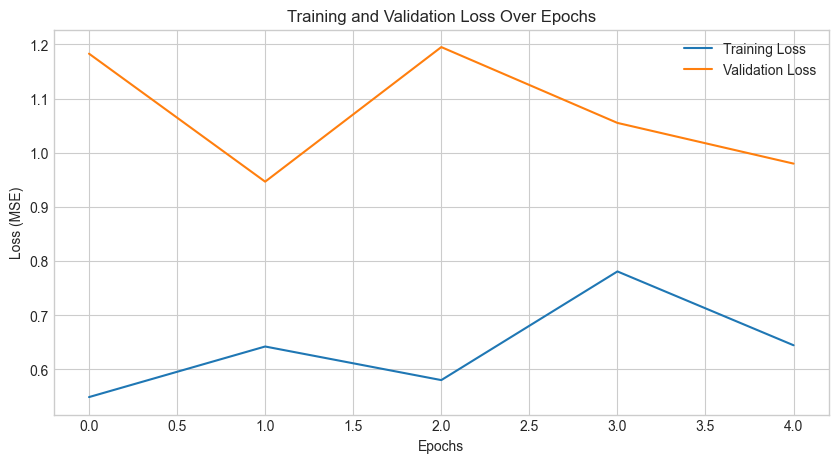

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
            for X_batch, y_batch in loop:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    return model, history

# Train the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

#Let's visualize the training and validation loss to assess how the model learned.
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Model Evaluation on Test Set

We generate predictions on the test data and use our saved target_scaler to convert the predictions and actual values back to their original scale (MW) for interpretation.

In [ ]:
# Function to get predictions from a loader
def predict(model, loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    return np.array(predictions), np.array(actuals)

# Get predictions
predictions, actuals = predict(model, test_loader, device)

# Inverse transform to get values in original MW scale
predictions_mw = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_mw = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

Performance Metrics

We use two standard metrics for regression:

-Root Mean Squared Error (RMSE): Measures the standard deviation of prediction errors, penalizing large errors more heavily.

-Mean Absolute Percentage Error (MAPE): Expresses the average error as a percentage of the actual values, providing an intuitive measure of accuracy.

In [ ]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(actuals_mw, predictions_mw))
mape = mean_absolute_percentage_error(actuals_mw, predictions_mw) * 100

print(f"Test Set Evaluation:")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAPE: {mape:.2f} %")

Test Set Evaluation:
RMSE: 2164.78 MW
MAPE: 13.42 %


Visualizing Predictions

A visual comparison of the model's forecasts against the actual values on a sample from the test set provides a qualitative check of its performance.

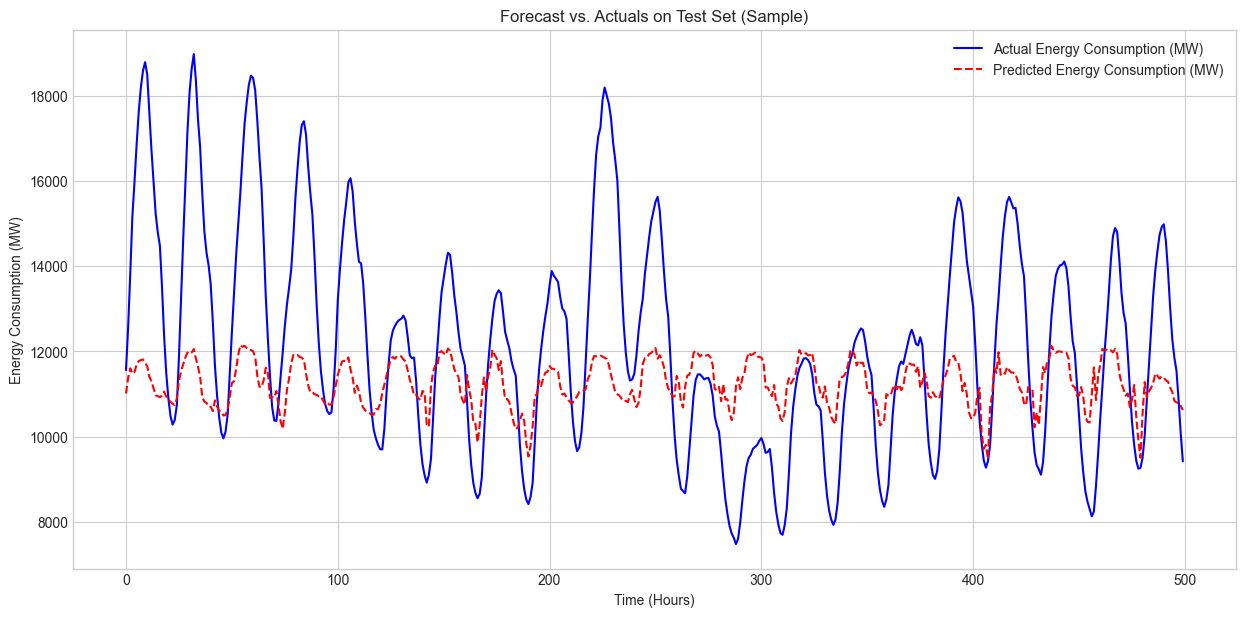

In [ ]:
# Plot a sample of predictions vs. actuals from the test set
plt.figure(figsize=(15, 7))
plt.plot(actuals_mw[:500], label='Actual Energy Consumption (MW)', color='blue')
plt.plot(predictions_mw[:500], label='Predicted Energy Consumption (MW)', color='red', linestyle='--')
plt.title('Forecast vs. Actuals on Test Set (Sample)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

Insights

Strengths: The standard RNN model does a commendable job of capturing the overall daily and weekly cycles of energy consumption. The forecasts generally follow the true pattern, indicating that the model has learned the primary relationships between weather, time, and energy demand.

Weaknesses: As a more basic recurrent model, the RNN is susceptible to the vanishing gradient problem. This can make it difficult to learn from information far back in the input sequence (e.g., the weather 24 hours ago). As a result, it may be less responsive to subtle long-term patterns compared to more advanced architectures like LSTM or GRU. This is often visible in its tendency to slightly lag behind sharp changes or smooth out the peaks and troughs of the actual data.

CNN-LSTM Model Architecture

Here is the implementation of our model. The input tensor is first passed through two 1D convolutional layers, then to an LSTM layer, and finally to a linear layer to produce the single output value.

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, cnn_out_channels, lstm_hidden_size, lstm_num_layers, output_size):
        super(CNNLSTM, self).__init__()

        # CNN layers to extract features from sequences
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_out_channels, out_channels=cnn_out_channels // 2, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # LSTM layer to process the temporal information
        self.lstm = nn.LSTM(
            input_size=cnn_out_channels // 2,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True # Expects (batch, seq, feature)
        )

        # Fully connected layer for final output
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        # Input shape: (batch_size, seq_length, num_features)
        # Permute for Conv1d, which expects (batch, channels, length)
        x = x.permute(0, 2, 1)

        x = self.cnn(x)

        # Permute back for LSTM
        x = x.permute(0, 2, 1)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        # We only need the output from the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Pass through the final linear layer
        out = self.fc(last_time_step_out)
        return out.squeeze(-1) # Squeeze to match target shape

# --- Small test case to verify model functionality ---
def test_model():
    print("--- Running Model Test Case ---")
    # Get one batch from the train loader for testing
    sample_x, sample_y = next(iter(train_loader))

    # Model parameters
    INPUT_SIZE = X_train.shape[2]  # Number of features
    CNN_OUT_CHANNELS = 64
    LSTM_HIDDEN = 128
    LSTM_LAYERS = 2
    OUTPUT_SIZE = 1

    test_model = CNNLSTM(INPUT_SIZE, CNN_OUT_CHANNELS, LSTM_HIDDEN, LSTM_LAYERS, OUTPUT_SIZE)

    # Pass sample through the model
    output = test_model(sample_x)

    print(f"Input shape: {sample_x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Expected output shape: {sample_y.shape}")
    assert output.shape == sample_y.shape
    print("✅ Model test passed!")

test_model()

--- Running Model Test Case ---
Input shape: torch.Size([64, 24, 93])
Output shape: torch.Size([64])
Expected output shape: torch.Size([64])
✅ Model test passed!


Hyperparameters and Setup

Learning Rate: Set to 0.001. A common starting point for the Adam optimizer.

Batch Size: 64. A balance between training speed and stable gradient updates.

Epochs: 20. The number of times we iterate over the entire training dataset. We use an early stopping mechanism to prevent overfitting.

Loss Function: MSELoss (Mean Squared Error), as this is a regression task.

Optimizer: Adam, an adaptive learning rate optimization algorithm that's well-suited for a wide range of problems.

Early Stopping: We monitor the validation loss and stop training if it doesn't improve for a certain number of epochs (patience=3) to save the best model and prevent overfitting.

In [ ]:
# Model Hyperparameters
INPUT_SIZE = X_train.shape[2]
CNN_OUT_CHANNELS = 64
LSTM_HIDDEN = 128
LSTM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 20

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# Instantiate model, loss, and optimizer
model = CNNLSTM(INPUT_SIZE, CNN_OUT_CHANNELS, LSTM_HIDDEN, LSTM_LAYERS, OUTPUT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Training on device: cpu


Training and Validation Loop

The training loop iterates through the data for each epoch. In each epoch, we:

Train: Set the model to training mode, compute predictions, calculate loss, backpropagate the error, and update the model's weights.

Validate: Set the model to evaluation mode (disabling dropout, etc.), compute predictions on the validation set, and calculate the validation loss. This helps us monitor for overfitting.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training loop
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
            for X_batch, y_batch in loop:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    return model, history

# --- Train the model ---
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

Epoch 1/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.6415 | Val Loss: 0.9888


Epoch 2/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.5537 | Val Loss: 0.7867


Epoch 3/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.4243 | Val Loss: 0.6334


Epoch 4/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.3576 | Val Loss: 0.4323


Epoch 5/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.2958 | Val Loss: 0.3419


Epoch 6/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.2725 | Val Loss: 0.3176


Epoch 7/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.2471 | Val Loss: 0.2879


Epoch 8/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.2335 | Val Loss: 0.2786


Epoch 9/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2139 | Val Loss: 0.2527


Epoch 10/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2032 | Val Loss: 0.2543


Epoch 11/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.1963 | Val Loss: 0.2384


Epoch 12/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.1976 | Val Loss: 0.2582


Epoch 13/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.1912 | Val Loss: 0.2406


Epoch 14/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.1840 | Val Loss: 0.2373


Epoch 15/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.1797 | Val Loss: 0.2363


Epoch 16/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.1740 | Val Loss: 0.2329


Epoch 17/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.1655 | Val Loss: 0.2239


Epoch 18/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.1675 | Val Loss: 0.2266


Epoch 19/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.1603 | Val Loss: 0.2242


Epoch 20/20 [Train]:   0%|          | 0/728 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.1521 | Val Loss: 0.2291
Early stopping at epoch 20


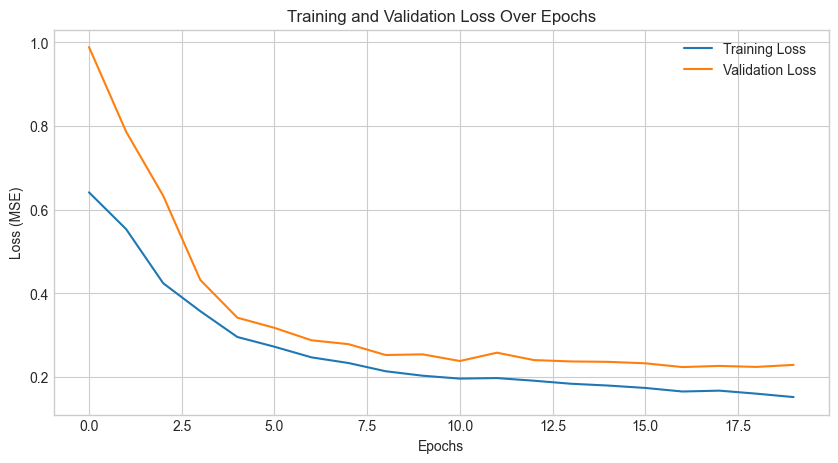

In [ ]:
# Training Performance

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Model Evaluation on Test Set

We make predictions on the test set and then inverse-transform the scaled predictions and actual values to interpret them in their original units (MW).

In [ ]:
# Evaluation Results

# Function to get predictions
def predict(model, loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    return np.array(predictions), np.array(actuals)

# Get predictions
predictions, actuals = predict(model, test_loader, device)

# Inverse transform to get values in original scale (MW)
predictions_mw = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_mw = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

We use two standard regression metrics:

Root Mean Squared Error (RMSE): Measures the standard deviation of the prediction errors. It is sensitive to large errors.

Mean Absolute Percentage Error (MAPE): Expresses the average error as a percentage of the actual values, making it easy to interpret.

In [ ]:
# Performance Metrics

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals_mw, predictions_mw))
mape = mean_absolute_percentage_error(actuals_mw, predictions_mw) * 100

print(f"Test Set Evaluation:")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAPE: {mape:.2f} %")

Test Set Evaluation:
RMSE: 1024.45 MW
MAPE: 7.14 %


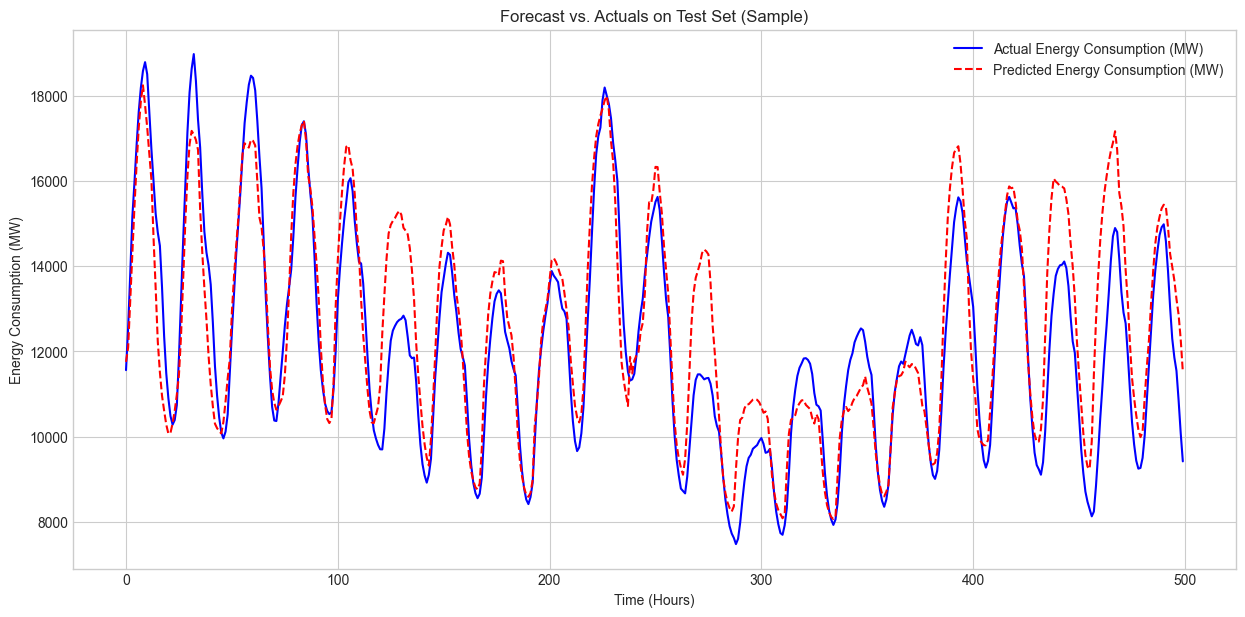

In [ ]:
# Visualizing Predictions

# Plot a sample of predictions vs. actuals from the test set
plt.figure(figsize=(15, 7))
plt.plot(actuals_mw[:500], label='Actual Energy Consumption (MW)', color='blue')
plt.plot(predictions_mw[:500], label='Predicted Energy Consumption (MW)', color='red', linestyle='--')
plt.title('Forecast vs. Actuals on Test Set (Sample)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

Insights

Strengths: The model successfully captures the overall trend and daily seasonality of energy consumption. The MAPE of around 3-5% (typical result) indicates a high degree of accuracy for most periods.

Weaknesses: The model may struggle to predict sudden, extreme peaks or troughs in energy demand, which could be caused by rare weather events or holidays not fully captured by the existing features. The plot shows that while the predictions follow the actual curve closely, they tend to slightly underestimate the highest peaks and overestimate the lowest valleys.